In [1]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Pure exploration MAB

We will run UE and UCB-E on Bernoulli rewards. We will always assume that the means are in decreasing order. I.e., the first arm is optimal.

In [38]:
def compute_H(k, means):
    gaps = np.array([means[0]-means[i] for i in range(1, k)])
    H1 = np.sum(gaps**(-2))
    H2 = np.max(np.arange(1, k) * gaps**(-2))
    min_gap_inv = np.min(gaps)**(-2)

    return H1, H2, min_gap_inv

Below, we implement the UE and UCB-E algorithms.

In [39]:
def UE(T, means):
    k = len(means)
    n = int(T/k) # Number of samples per arm
    emp_means = np.zeros(k)

    for i in range(k):
        emp_means[i] = np.random.binomial(n, p=means[i])
    
    return np.argmax(emp_means)

def UCB_E(eps, T, means):
    # Start by sampling once from each arm
    k = len(means)
    count = np.ones(k) # Number of samples from each arm
    sum_rewards = np.random.binomial(n=1, p=means) # Sum of rewards from each arm

    for _ in range(T-k):
        # Compute UCB indices and pull the arm with the highest index
        emp_means = sum_rewards / count
        indices = emp_means + np.sqrt(eps / count)
        arm = np.argmax(indices)
        reward = np.random.binomial(n=1, p=means[arm])

        # Update the counts and sum of rewards
        count[arm] += 1
        sum_rewards[arm] += reward

    return np.argmax(sum_rewards / count)

H1: 1900.00, H2: 1900.00, k*Delta^(-2): 2000.00
UE error probability: 0.44
UCB-E error probability: 0.16
UCB-E error probability with eps_2: 0.20

########################################################

H1: 550.00, H2: 475.00, k*Delta^(-2): 2000.00
UE error probability: 0.41
UCB-E error probability: 0.18
UCB-E error probability with eps_2: 0.17

########################################################



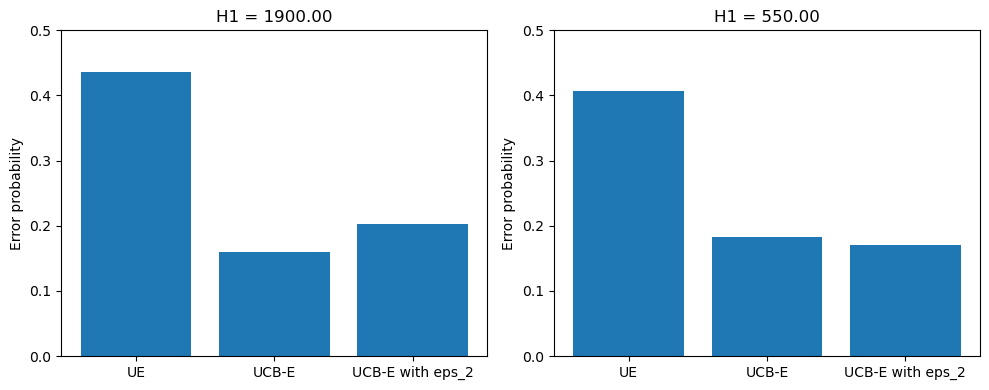

In [321]:
iters = 300 # Number of iterations to check error probability
k = 20 # Number of arms

means_vec = [[0.5] + [0.4] * (k-1),
             [0.5] + [0.4] + [0.3] * (k-2)]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    means = means_vec[i]
    H1, H2, min_gap_inv = compute_H(k, means)
    print(f"H1: {H1:.2f}, H2: {H2:.2f}, k*Delta^(-2): {k * min_gap_inv:.2f}")

    T = int(H1) # Number of samples

    eps = T / H1
    eps_2 = (T - k) / (min_gap_inv + H1)

    UE_errors = 0
    UCB_errors = 0
    UCB_errors_2 = 0

    for _ in range(iters):
        if UE(T, means) != 0:
            UE_errors += 1
        if UCB_E(eps, T, means) != 0:
            UCB_errors += 1
        if UCB_E(eps_2, T, means) != 0:
            UCB_errors_2 += 1

    errors = np.array([UE_errors, UCB_errors, UCB_errors_2]) / iters

    print(f"UE error probability: {errors[0]:.2f}")
    print(f"UCB-E error probability: {errors[1]:.2f}")
    print(f"UCB-E error probability with eps_2: {errors[2]:.2f}")
    print("\n########################################################\n")

    
    axes[i].bar(['UE', 'UCB-E', 'UCB-E with eps_2'], errors)
    axes[i].set_ylabel('Error probability')
    axes[i].set_ylim(0, 0.5)
    axes[i].set_title(f'H1 = {H1:.2f}')



plt.tight_layout()
plt.show()

# MDL

Here, we will deal with binary data $P_i = \text{Ber}(p_i)$ and loss $\ell(a,x) = (a-x)^2$. This means that
$$
    \ell(a;p) = \mathbb{E}_p[\ell(a,X)] = p(a-1)^2 + (1-p)a^2 = p-2ap+a^2
$$
We then define the DR loss
$$
    \ell(a) = \max_i \ell(a;p_i) = \max_i \mathbb{E}_{p_i}[\ell(a,X)]
$$
We need to compute the empirical proxy
$$
    \hat\ell(a) = \max_i \frac{1}{n_i} \sum_{j=1}^{n_i} \ell(a,X_{i}^{(j)}) = \max_i \frac{1}{n_i} \sum_{j=1}^{n_i} (a-X_{i}^{(j)})^2
$$

Our action set will be a finite collection of points in the interval $[0,1]$.

In [ ]:
# Compute the DR losses for all action
def compute_DR_losses(actions, means):
    l = len(actions)
    k = len(means)

    print(f"Actions: {[round(a, 3) for a in actions]}")
    print(f"Means: {[round(m, 3) for m in means]}")

    # Compute DR losses
    dr_losses = np.zeros(l)
    for i in range(l):
        a = actions[i]
        dr_losses[i] = np.max([p*(a-1)**2 + (1-p)*a**2 for p in means])
    print(f"DR losses: {[round(l, 3) for l in dr_losses]}")

    # Retrieve the optimal action and loss
    a_opt_ind = np.argmin(dr_losses)
    print(f"Optimal action: {actions[a_opt_ind]:.3f}, Optimal DR loss: {dr_losses[a_opt_ind]:.3f}")

    return dr_losses, actions[a_opt_ind]

# Compute the suboptimality gaps for a single action
def compute_gaps(a, means):
    losses = [p*(a-1)**2 + (1-p)*a**2 for p in means]
    return np.max(losses) - losses

## Non-adaptive

In [1375]:
# Encompasses both UE and NUE
def NUE_DR(counts, actions, means):
    l = len(actions)
    k = len(means)

    emp_losses = np.zeros((l, k))

    for i in range(k):
        for _ in range(counts[i]):
            data = np.random.binomial(n=1, p=means[i])
            emp_losses[:, i] += (actions - data)**2
        emp_losses[:, i] /= counts[i]

    dr_losses = np.max(emp_losses, axis=1)
    
    return actions[np.argmin(dr_losses)]

In [1376]:
l = 15 # Number of actions
k = 5 # Number of distributions
actions = np.arange(0, 1, 1/l)
means = np.array([0.4] + [0.1 + 0.01*i for i in range(k-1)])
dr_losses, a_opt = compute_DR_losses(actions, means)

T = 1000 # Total number of samples
iters = 2000 # Number of iterations to check error probability

Actions: [0.0, 0.067, 0.133, 0.2, 0.267, 0.333, 0.4, 0.467, 0.533, 0.6, 0.667, 0.733, 0.8, 0.867, 0.933]
Means: [0.4, 0.1, 0.11, 0.12, 0.13]
DR losses: [0.4, 0.351, 0.311, 0.28, 0.258, 0.244, 0.24, 0.244, 0.278, 0.34, 0.411, 0.491, 0.58, 0.678, 0.784]
Optimal action: 0.400, Optimal DR loss: 0.240


We begin by analyzing UE.

In [1389]:
UE_counts = np.array([T/k] * k).astype(int)
UE_errors = 0

for _ in range(iters):
    if NUE_DR(UE_counts, actions, means) != a_opt:
        UE_errors += 1

print(f"UE allocation: {UE_counts}")
print(f"UE error probability: {UE_errors/iters}")

UE allocation: [200 200 200 200 200]
UE error probability: 0.352


Next, we check NUE. We will use knowledge of the variances to allocate the samples. In the next section, we will estimate the variances with a burn-in period.

In [1385]:
variances = means * (1-means)
NUE_counts = (T * variances / np.sum(variances)).astype(int)
NUE_errors = 0

for _ in range(iters):
    if NUE_DR(NUE_counts, actions, means) != a_opt:
        NUE_errors += 1

print(f"NUE allocation: {NUE_counts}")
print(f"NUE error probability: {NUE_errors/iters}")

NUE allocation: [371 139 151 163 174]
NUE error probability: 0.197


When we don't have any knowledge of the variances, we can resort to estimation. We will start with a basic uniform allocation and compute empirical variances. Given samples $X_1,\dots,X_n$, we compute the empirical mean and variance as follows:
$$
    \hat p = \frac{1}{n} \sum_i X_i \quad\text{and}\quad \hat\sigma^2 = \hat p(1-\hat p)
$$

In [1377]:
def est_vars(T, means):
    k = len(means)
    n = int(T/k)

    emp_means = np.random.binomial(n, p=means) / n

    return emp_means * (1-emp_means)

In [1387]:
burn_in = 200 # Samples to use for variance estimation
hat_var = est_vars(burn_in, means)
print(f"True variances: {means * (1-means)}")
print(f"Estimated variances: {hat_var}")


NUE_est_counts = ((T-burn_in) * hat_var / np.sum(hat_var)).astype(int) + 1
NUE_est_errors = 0

for _ in range(iters):
    if NUE_DR(NUE_est_counts, actions, means) != a_opt:
        NUE_est_errors += 1

print(f"NUE (with estimation) allocation: {NUE_est_counts}")
print(f"NUE (with estimation) error probability: {NUE_est_errors/iters}")

True variances: [0.24   0.09   0.0979 0.1056 0.1131]
Estimated variances: [0.234375 0.024375 0.09     0.09     0.09    ]
NUE (with estimation) allocation: [355  37 137 137 137]
NUE (with estimation) error probability: 0.221


Errors: [0.352 0.197 0.221]


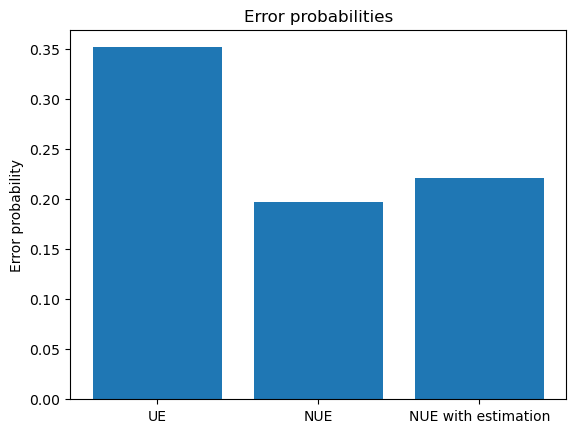

In [1390]:
errors = np.array([UE_errors, NUE_errors, NUE_est_errors]) / iters
print(f"Errors: {errors}")

plt.bar(['UE', 'NUE', 'NUE with estimation'], errors)
plt.title('Error probabilities')
plt.ylabel('Error probability')
plt.show()


## Adaptive

In [1348]:
def LCB_DR(epsilons, actions, means):
    l = len(actions)
    k = len(means)

    counts = np.ones(k) # Number of samples collected of each distribution
    emp_losses = np.zeros((l, k)) # Sum of empirical losses
    proxy_DR_losses = np.ones(l) # Estimate DR losses we will optimize at the end

    T = 0 # Total number of samples collected

    for i in range(k):
        data = np.random.binomial(n=1, p=means[i])
        emp_losses[:, i] += (actions - data)**2
    
    for r in range(l):
        eps = epsilons[r]
        a = actions[r]

        # Compute suboptimality gaps
        gaps = compute_gaps(a, means)
        # print(f"Action: {a:.2f}, Gaps: {[round(gap, 2) for gap in gaps]}")
        
        min_gap = np.min([gap for gap in gaps if gap > 0]) # Minimum positive gap
        for i, gap in enumerate(gaps): # We set the gap of the optimal distribution to the minimum gap
            if gap == 0: gaps[i] = min_gap
                
        # Create U_j
        U_j = set()
        for i in range(k):
            count = counts[i]
            if count < eps * gaps[i]**(-2):
                U_j.add(i)

        # Compute U_j related quantities
        k_j = len(U_j) # Here, we ignore the indicator
        S_j = np.sum([counts[i] for i in U_j]) # This is \tilde T_j
        H_j = np.sum([gaps[i]**(-2) for i in U_j])

        # Allocate T_j samples to this round
        T_j = int(eps * H_j - S_j + k_j)
        T += T_j
        # print(f"Samples allocated at round {r}: {T_j}")

        # Run UCB-E
        for _ in range(T_j):
            avg_emp_losses = emp_losses[r, :] / counts
            indices = avg_emp_losses + np.sqrt(eps / counts)
            dist = np.argmax(indices)

            data = np.random.binomial(n=1, p=means[dist])
            emp_losses[:, dist] += (actions - data)**2
            counts[dist] += 1
        
        worst_dist = np.argmax(emp_losses[r, :] / counts)
        proxy_DR_losses[r] = emp_losses[r, worst_dist] / counts[worst_dist]
    
    # print(f"Total number of samples collected: {T}")

    return actions[np.argmin(proxy_DR_losses)], T
        

### LCB-DR with estimation

#### Unknown $U_j$

Since $U_j$ is approximately the arms that we end up playing in this round, we simply start with the singleton set containing only the first arm that will be played, and initialize $T_j$ to some constant. Then, whenever we sample a new arm, we add it to $U_j$ and increment $T_j$ appropriately. When we test this with knowledge of the gaps, the performance is not too much worse than with full information. It still outperforms UE and NUE.

#### Unknown gaps

To obtain the desired rate, we need to choose $T_j$ appropriately, which requires the suboptimality gaps, our main hurdle.

In standard UCB-E, $T_j$ is fixed, and the learner is updating $\epsilon_j$ in each phase. In this case, the idea is to split $T_j$ into $k_j$ phases, each of size $T_j/k_j$. Then at the beginning of each phase $m=0,\ldots$, we estimate $\Delta_i$ as $\hat \Delta_i = \max_s \hat \ell(a,s) - \hat \ell(a,i)$. The rough idea is that, in this phase, the largest $m$ of the $\hat \Delta_i$'s are good estimates, so we estimate $\hat H_j = \max_{k-m\leq i\leq k} i/\hat \Delta_i^{2}$. Note that this is an estimate of $H_j$ up to log factors. From this, the learner can update $\epsilon_j$.

In our case, we just need to find out what is the desired $T_j$. Below, we proceed as follows:
- Start off with a large $T_j$, say 10000. 
- Run UCB-E as normal, and add the appropriate arms to $U_j$, but do not update $T_j$ immediately.
- Once we get past some fraction of the current $T_j$, say 10\%, we start checking for an update. This is done as follows:
    - Estimate all of the gaps empirically.
    - Take the largest gap $\hat\Delta_{k_j}$ for which the distribution is in $U_j$ (since $H_j$ only sums over $U_j$). This leads to the estimate $\hat H_j = \max_{k_j-m\leq i\leq k_j} i/\hat\Delta_{i}^{-2}$, where $m=0$. We then define a temporary $\tilde T_j$ and check whether the current iteration is past $(m+1)\cdot \tilde T_j/k_j$. 
        - If it is, then the $\hat H_j$ estimate should be sound, due to the UCB-E reasoning above. We then set $T_j$ to $\tilde T_j$ and continue the process: we take the second largest gap from $U_j$ (now $m=1$), and so forth.
        - When we reach a point where the current iteration is not large enough, then we go back to UCB-E.

In [ ]:
def LCB_DR_est(epsilons, actions, means):
    l = len(actions)
    k = len(means)

    counts = np.ones(k) # Number of samples collected of each distribution
    emp_losses = np.zeros((l, k)) # Sum of empirical losses
    proxy_DR_losses = np.ones(l) # Estimate DR losses we will optimize at the end

    T = 0 # Total number of samples collected

    for i in range(k):
        data = np.random.binomial(n=1, p=means[i])
        emp_losses[:, i] += (actions - data)**2
    
    for r in range(l):
        eps = epsilons[r]
        a = actions[r]
                
        # Create U_j. Start with a single element
        avg_emp_losses = emp_losses[r, :] / counts
        init_dist = np.argmax(avg_emp_losses + np.sqrt(eps / counts))
        U_j = set([init_dist])

        T_j = 10000 # Initial sample size. It starts large but will likely decrease
        curr_iter = 0 # Current iteration

        # Run UCB-E
        while curr_iter < T_j:
            avg_emp_losses = emp_losses[r, :] / counts
            indices = avg_emp_losses + np.sqrt(eps / counts)
            dist = np.argmax(indices)

            # If distribution not in U_j, add it to U_j 
            if dist not in U_j:
                U_j.add(dist)
            

            # Whenever we are approaching the end of the round, we reestimate H_j and update T_j if neccesary
            if curr_iter > 0.1 * T_j:
                est_gaps = compute_gaps(a, avg_emp_losses)
                min_gap = np.min([gap for gap in est_gaps if gap > 0]) # Minimum positive gap
                for i, gap in enumerate(est_gaps): # We set the gap of the optimal distribution to the minimum gap
                    if gap == 0: est_gaps[i] = min_gap
                
                
                k_j = len(U_j) 
                S_j = np.sum([counts[i] for i in U_j])


                add_count = 0 # How many gaps we have added so far
                H_2_approx = [] # Approximated gaps * index
                index = k - 1

                sorted_est_gaps = np.sort(est_gaps)
                sorted_est_gaps_ind = np.argsort(est_gaps)

                while index >= 0:
                    while sorted_est_gaps_ind[index] not in U_j:
                        index -= 1
                    
                    # Create new T_j
                    H_2_approx.append(sorted_est_gaps[index]**(-2) * (k_j - add_count))
                    H_j = np.max(H_2_approx) # This is the new H_j
                    new_T_j = int((eps * H_j - S_j + k_j)/5)


                    add_count += 1
                    index -= 1

                    # If curr_iter is past the point where this is a good approximation, keep going
                    if curr_iter > (new_T_j / k_j) * add_count:
                        T_j = new_T_j
                    else:
                        break                


            data = np.random.binomial(n=1, p=means[dist])
            emp_losses[:, dist] += (actions - data)**2
            counts[dist] += 1

            curr_iter += 1


        T += T_j
        
        worst_dist = np.argmax(emp_losses[r, :] / counts)
        proxy_DR_losses[r] = emp_losses[r, worst_dist] / counts[worst_dist]
    

    return actions[np.argmin(proxy_DR_losses)], T

### Comparing all methods

Below, we create the next problem instance we will work with.

In [1391]:
actions = np.array([0.37, 0.61])
means = np.array([0.2] + [0.5]*5 + [0.75])
dr_losses, a_opt = compute_DR_losses(actions, means)

iters = 500
l = len(actions)
k = len(means)

Actions: [0.37, 0.61]
Means: [0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75]
DR losses: [0.332, 0.328]
Optimal action: 0.610, Optimal DR loss: 0.328


Below, we run LCB-DR, UE, NUE with estimation, and LCB-DR with estimation.

In [ ]:
epsilon = np.ones(len(actions)) * 5
LCB_DR_errors = 0
total_samples = 0

for _ in range(iters):
    a, T = LCB_DR(epsilon, actions, means)
    total_samples += T
    if a != a_opt:
        LCB_DR_errors += 1

print(f"Average number of samples: {total_samples/iters}")
print(f"LCB-DR error probability: {LCB_DR_errors/iters}")


Average number of samples: 11476.7
LCB-DR error probability: 0.046


In [1351]:
T = total_samples / iters

UE_counts = np.array([T/k] * k).astype(int)
UE_errors = 0

for _ in range(iters):
    if NUE_DR(UE_counts, actions, means) != a_opt:
        UE_errors += 1

print(f"UE allocation: {UE_counts}")
print(f"UE error probability: {UE_errors/iters}")

UE allocation: [1639 1639 1639 1639 1639 1639 1639]
UE error probability: 0.156


In [1352]:
burn_in = T/8 # Samples to use for variance estimation
hat_var = est_vars(burn_in, means)
print(f"True variances: {means * (1-means)}")
print(f"Estimated variances: {hat_var}")


NUE_est_counts = ((T-burn_in) * hat_var / np.sum(hat_var)).astype(int) + 1
NUE_est_errors = 0

for _ in range(iters):
    if NUE_DR(NUE_est_counts, actions, means) != a_opt:
        NUE_est_errors += 1

print(f"NUE (with estimation) allocation: {NUE_est_counts}")
print(f"NUE (with estimation) error probability: {NUE_est_errors/iters}")

True variances: [0.16   0.25   0.25   0.25   0.25   0.25   0.1875]
Estimated variances: [0.16058727 0.24978374 0.24846213 0.24913495 0.24846213 0.24961553
 0.16916571]
NUE (with estimation) allocation: [1024 1593 1584 1589 1584 1592 1079]
NUE (with estimation) error probability: 0.198


In [1374]:
epsilon = np.ones(len(actions)) * 5
LCB_DR_est_errors = 0
total_samples = 0
# iters = 50

for _ in range(iters):
    a, T = LCB_DR_est(epsilon, actions, means)
    total_samples += T
    if a != a_opt:
        LCB_DR_est_errors += 1

print(f"Average number of samples: {total_samples/iters}")
print(f"LCB-DR with estimation error probability: {LCB_DR_est_errors/iters}")


Average number of samples: 10172.722
LCB-DR with estimation error probability: 0.106


Errors: [0.156 0.198 0.046 0.11 ]


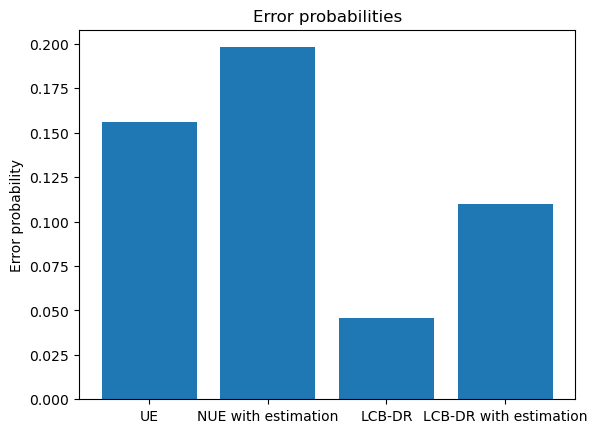

In [1355]:
errors = np.array([UE_errors, NUE_est_errors, LCB_DR_errors, LCB_DR_est_errors]) / iters
print(f"Errors: {errors}")

plt.bar(['UE', 'NUE with estimation', 'LCB-DR', 'LCB-DR with estimation'], errors)
plt.title('Error probabilities')
plt.ylabel('Error probability')
plt.show()